# Logit Lens 🔎

## Introduction to Logit Lens

Logit Lens is a powerful tool that grants us a simplified yet insightful interpretability lens into the inner workings of GPT. By applying the same predictive function to intermediate layer activations, we gain a glimpse into the model's evolving understanding after each processing stage. Unlike traditional approaches focusing on how beliefs are updated within a step, the logit lens shifts the spotlight to what GPT "believes" at each juncture.

📗 Read more about Logit Lens from nostalgebraist's blog post on LessWrong, [here](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens)

💻 You can find a colab version for the nostalgebraist's blog code [here](https://colab.research.google.com/drive/1-nOE-Qyia3ElM17qrdoHAtGmLCPUZijg?usp=sharing)

# Setup (Ignore)

In [1]:
# Install nnsight

!pip install nnsight

from nnsight import LanguageModel
from typing import List, Callable
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import clear_output

clear_output()

In [2]:
# Load gpt2

model = LanguageModel("openai-community/gpt2", device_map="auto", dispatch=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# GPT2 Model Architecture

In [3]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  (generator): WrapperModule()
)


Here we trace and analyze activations at specified layers, computing probabilities for each token through the softmax function. By aggregating these probabilities from different layers, the function provides insights into the model's confidence at various stages

In [4]:
prompt= "The Eiffel Tower is in the city of"
layers = model.transformer.h
probs_layers = []

with model.trace() as tracer:
    with tracer.invoke(prompt) as invoker:
        for layer_idx, layer in enumerate(layers):
            # Process layer output through the model's head and layer normalization
            layer_output = model.lm_head(model.transformer.ln_f(layer.output[0]))

            # Apply softmax to obtain probabilities and save the result
            probs = torch.nn.functional.softmax(layer_output, dim=-1).save()
            probs_layers.append(probs)

probs = torch.cat([probs.value for probs in probs_layers])

# Find the maximum probability and corresponding tokens for each position
max_probs, tokens = probs.max(dim=-1)

# Decode token IDs to words for each layer
words = [[model.tokenizer.decode(t).encode("unicode_escape").decode() for t in layer_tokens]
    for layer_tokens in tokens]

# Access the 'input_ids' attribute of the invoker object to get the input words
input_words = [model.tokenizer.decode(t) for t in invoker.inputs[0]["input_ids"][0]]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


## Visualizing GPT-2 Layer Interpretations

Now we will visualize the prediction of the GPT-2 model while processing the string *'The Eiffel Tower is in the city of _'* and we'll explore the interpretations of each layer within the GPT2Block, gaining insights into what each layer believes could be the next word for every input word.

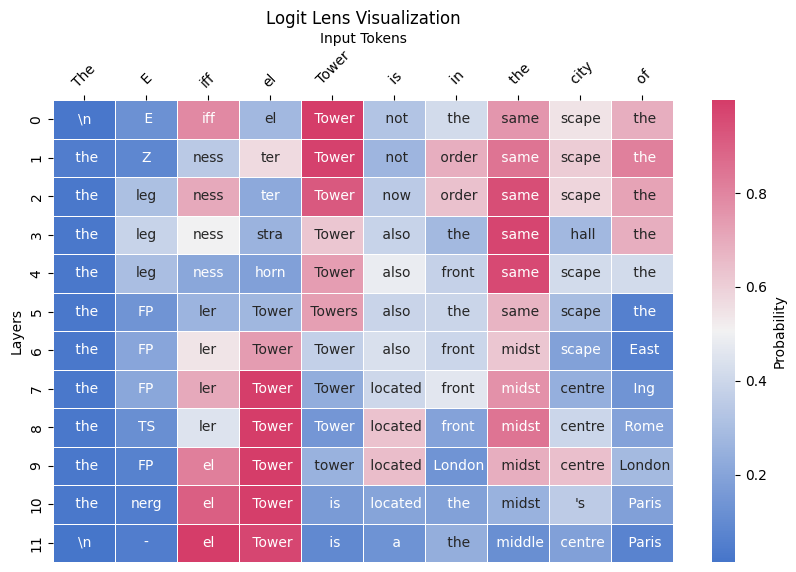

In [8]:
output_words = input_words[1:] + ["?"]

cmap = sns.diverging_palette(255, 0, n=len(words[0]), as_cmap=True)

plt.figure(figsize=(10, 6))
ax=sns.heatmap(max_probs.detach().numpy(), annot=np.array(words), fmt='', cmap=cmap, linewidths=.5, cbar_kws={'label': 'Probability'})

plt.title('Logit Lens Visualization')
plt.xlabel('Input Tokens')
plt.ylabel('Layers')

plt.yticks(np.arange(len(words)) + 0.5, range(len(words)))

plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position("top")
plt.xticks(np.arange(len(input_words)) + 0.5, input_words, rotation=45)

plt.show()


The vertical axis indexes the layers, zero-indexed from 0 to 11. The top guess for each token, according to the model's activations at a given layer, is printed in each cell. The colors show the probability associated with the top guess.